In [1]:
### RUN EVERY TIME: COMTRADE DATASETS EXTRACTING

In [2]:
### RUN EVERY TIME: INITIALIZATION

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import requests
import json ### To correct JSON structure before unpacking
import gc
import datetime
import time
import itertools

In [3]:
### RUN EVERY TIME: VERSION CONTROL

from platform import python_version
print('python version: ', python_version())
print('numpy version: ', np.__version__)
print('pandas version: ', pd.__version__)

python version:  3.7.4
numpy version:  1.17.2
pandas version:  0.25.3


In [4]:
### RUN EVERY TIME: MAIN CONSTANTS

### MultiIndex level slice constant:
All = slice(None)
### Universe path:
str_path_universe = 'Data_Files/Source_Files/acadian_universe.xlsx'
### Dates:
str_date_end = '2021-12-31'
date_start = pd.Timestamp('1989-12-29')
date_end = pd.Timestamp(str_date_end)
date_ison = pd.Timestamp('1994-12-31')
### NA for MS Excel files:
list_na_excel_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null',
                        '#N/A Requesting Data...', '#N/A Invalid Security', '#N/A Field Not Applicable', '---']
### UN Comtrade authentication:
unc_login = 'pavelb'
unc_pass = 'bodoapux'
unc_token = 'wqgBfTCn0Idq0LZWWAFKgj3YQYRKczgdnfmlQ3CkanmvQzoAlnL1oK1OJ0yVoCjSLjkUozAj0/dD4eCkSLJO/6pLCqK+iweXMqMazaADI+YqBOUPFySpbXM0CEZepZEuNl5bqxg50EPVB5lCrifsoA=='
### UN Comtrade raw data containers:
str_path_unc_raw_comm_annual = 'Data_Files/Source_Files/unc_raw_comm_annual.h5'
str_path_unc_raw_serv_annual = 'Data_Files/Source_Files/unc_raw_serv_annual.h5'
str_path_unc_raw_comm_monthly = 'Data_Files/Source_Files/unc_raw_comm_monthly.h5'
str_key_unc_raw = 'unc_raw'
### UN Comtrade adopted data containers:
str_path_unc_res_comm_annual = 'Data_Files/Source_Files/unc_res_comm_annual.h5'
str_path_unc_res_serv_annual = 'Data_Files/Source_Files/unc_res_serv_annual.h5'
str_path_unc_res_comm_monthly = 'Data_Files/Source_Files/unc_res_comm_monthly.h5'
str_key_unc_res = 'unc_res'
### UN Comtrade aggregated data containers:
str_path_unc_ind_annual = 'Data_Files/Source_Files/unc_industry_annual.h5'
str_key_ind_codes_only = 'gics_codes_only'
str_key_ind_descripted = 'gics_descripted'
### Connection tables path and sheets:
str_path_to_gics = 'Data_Files/Source_Files/goods_to_industries_HS.xlsx'
str_serv_sheet = 'EBOPS'
str_comm_sheet = 'AG2'

In [5]:
### DEFINING COUNTRY CODES EXTRACTOR

def get_country_codes(use_local_copy = False):  
    ### In case if URL is unavailable:
    if (use_local_copy):
        url_country_code = 'Data_Files/Source_Files/countrycode.html'
    ### Online extraction:
    else:
        url_country_code = 'https://countrycode.org/'
    df_full_codes = pd.read_html(url_country_code, index_col = 'COUNTRY')[0]
    df_full_codes[['ISO SHORT', 'ISO LONG']] = df_full_codes['ISO CODES'].str.split(' / ', expand = True)
    df_result = df_full_codes[['ISO SHORT', 'ISO LONG']].sort_index()    
    df_result.index = df_result.index.str.upper()
    ### Results output:
    return df_result

In [6]:
### DEFINING EXTRACTION UNIVERSE DATA FROM MS EXCEL SOURCE (TO BE IGNORED IN PRODUCT CODE)

def ison_membership_converting(str_path_universe, date_end, bool_daily = False, int_backfill_months = 0):
    ### Defining business-month-end reindexation on country level:
    def country_modify(ser_raw_country, date_end):
        ser_res_country = ser_raw_country.droplevel(0).resample('MS').last().resample('BM').last()
        range_country = pd.date_range(ser_res_country.index[0], date_end, freq = 'BM')
        return ser_res_country.reindex(range_country).ffill()
    ### Markets encoding table:
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM', 0: np.NaN}     
    ### Loading source file:
    df_raw_universe = pd.read_excel(engine = 'openpyxl', io = str_path_universe, sheet_name = 'Switchers', header = 0, parse_dates = True, index_col = [0, 1],
                                 na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                             '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'], keep_default_na = False)
    ### Converting source file:
    df_raw_universe.index.names = ['Country', 'Date']
    ser_raw_universe = df_raw_universe['Region']
    ser_raw_universe.fillna(0, inplace = True)
    ser_raw_universe.name = 'Market'
    ### By country reindexation and translation:
    ser_res_universe = ser_raw_universe.groupby('Country').apply(country_modify, date_end)
    ser_res_universe.index.names = ['Country', 'Date']
    ser_res_universe = ser_res_universe.replace(dict_markets).reorder_levels([1, 0]).sort_index() 
    ### Expanding membership for primary regions members by backfilling:
    if int_backfill_months:
        ### List of regions:
        list_region = list(ser_res_universe.dropna().unique())
        ### Initialising of collection of series with backfilled data for each region:
        list_ison_backfill = []
        ### Regions looping:
        for iter_region in list_region:
            ### Defining start of region date:
            date_first_valid = ser_res_universe.loc[ser_res_universe == iter_region].first_valid_index()[0]
            ### Creating dates index to backfilling:
            idx_date_backfill = pd.date_range(end = date_first_valid, periods = int_backfill_months + 1, freq = 'BM')[: -1]
            ### Creating primary countries index to backfilling:            
            idx_region_backfill = ser_res_universe.loc[ser_res_universe == iter_region].loc[date_first_valid, All].index.get_level_values('Country')
            ### Creating full index:
            idx_ison_backfill = pd.MultiIndex.from_product([idx_date_backfill, idx_region_backfill])
            ### Series with backfilled data:
            list_ison_backfill.append(pd.Series(iter_region, index = idx_ison_backfill))
        ### Combination of backfilled series and original ISON data:    
        ser_res_universe = ser_res_universe.combine_first(pd.concat(list_ison_backfill, axis = 0)).sort_index()  
        ser_res_universe.index.names = ['Date', 'Country']
    ### Converting to daily frequency:
    if bool_daily:
        ser_res_universe = ser_res_universe.reset_index('Country').groupby('Country').resample('B').ffill()['Market'].swaplevel().sort_index()    
    ### Results output:
    ser_res_universe.name = 'Market'
    return ser_res_universe

In [7]:
### RUN EVERY TIME: COMMON DATA EXTRACTION STEPS

### World Country Codes:
df_country_codes = get_country_codes()
### ISON membership history:
ser_ison_membership = ison_membership_converting(str_path_universe, pd.to_datetime(str_date_end))
int_ison_number = len(sorted(ser_ison_membership.index.get_level_values(1).unique()))
#df_country_codes[df_country_codes['ISO SHORT'].isin(ser_ison_membership.index.get_level_values('Country').unique())].to_excel('Data_Files/Test_Files/countries.xlsx')

In [8]:
### UN COMTRADE: DATA EXTRACTION

In [9]:
### UN COMTRADE: GENERAL DATA PREPARATION

### Constants:
int_unc_limit = 5
int_seconds_to_sleep = 2
### USA before 1981 code:
str_usa_1981 = '841'
### UN Comtrade country names to rename:
dict_map_to_replace = {'BOLIVIA (PLURINATIONAL STATE OF)': 'BOLIVIA',
                       'BOSNIA HERZEGOVINA': 'BOSNIA AND HERZEGOVINA',
                       'BR. INDIAN OCEAN TERR.': 'BRITISH INDIAN OCEAN TERRITORY',
                       'BR. VIRGIN ISDS': 'BRITISH VIRGIN ISLANDS',
                       'BRUNEI DARUSSALAM': 'BRUNEI',
                       'CABO VERDE': 'CAPE VERDE',
                       'CAYMAN ISDS': 'CAYMAN ISLANDS',
                       'CENTRAL AFRICAN REP.': 'CENTRAL AFRICAN REPUBLIC',
                       'CHRISTMAS ISDS': 'CHRISTMAS ISLAND',
                       'COCOS ISDS': 'COCOS ISLANDS',
                       'COOK ISDS': 'COOK ISLANDS',                    
                       'CURAÇAO': 'CURACAO',                          
                       'CZECHIA': 'CZECH REPUBLIC',                    
                       'DEM. REP. OF THE CONGO': 'DEMOCRATIC REPUBLIC OF THE CONGO',                          
                       'DOMINICAN REP.': 'DOMINICAN REPUBLIC',                    
                       'TIMOR-LESTE': 'EAST TIMOR',                          
                       'FALKLAND ISDS (MALVINAS)': 'FALKLAND ISLANDS',                    
                       'FAEROE ISDS': 'FAROE ISLANDS',                                           
                       'CHINA, HONG KONG SAR': 'HONG KONG',                          
                       'CÔTE D\'IVOIRE': 'IVORY COAST',                                           
                       'LAO PEOPLE\'S DEM. REP.': 'LAOS',                                         
                       'CHINA, MACAO SAR': 'MACAU',                          
                       'TFYR OF MACEDONIA': 'MACEDONIA',                    
                       'MARSHALL ISDS': 'MARSHALL ISLANDS',                          
                       'FS MICRONESIA': 'MICRONESIA',                    
                       'REP. OF MOLDOVA': 'MOLDOVA',                          
                       'NETH. ANTILLES': 'NETHERLANDS ANTILLES',                          
                       'DEM. PEOPLE\'S REP. OF KOREA': 'NORTH KOREA',                          
                       'N. MARIANA ISDS': 'NORTHERN MARIANA ISLANDS',                    
                       'STATE OF PALESTINE': 'PALESTINE',                          
                       'CONGO': 'REPUBLIC OF THE CONGO',                          
                       'RÉUNION': 'REUNION',                    
                       'RUSSIAN FEDERATION': 'RUSSIA',                          
                       'SOLOMON ISDS': 'SOLOMON ISLANDS',                    
                       'REP. OF KOREA': 'SOUTH KOREA',                                       
                       'UNITED REP. OF TANZANIA': 'TANZANIA',     
                       'OTHER ASIA, NES': 'TAIWAN',
                       'TURKS AND CAICOS ISDS': 'TURKS AND CAICOS ISLANDS',                    
                       'US VIRGIN ISDS': 'U.S. VIRGIN ISLANDS',                          
                       'USA': 'UNITED STATES',                          
                       'HOLY SEE (VATICAN CITY STATE)': 'VATICAN',                    
                       'VIET NAM': 'VIETNAM',                          
                       'WALLIS AND FUTUNA ISDS': 'WALLIS AND FUTUNA'
                      }

In [10]:
### UN COMTRADE: COUNTRIES DATA EXTRACTION AND MODIFICATION

def get_un_comtrade_country_id(df_country_codes):
    ### Getting UN Comtrade country info from post request:
    str_UNC_countries_set = 'http://comtrade.un.org/data/cache/partnerAreas.json'
    obj_UNC_countries_set = requests.post(str_UNC_countries_set)
    ### Object to dataframe transformation:
    list_UNC_countries = obj_UNC_countries_set.json()['results']
    df_UNC_countries = pd.DataFrame(list_UNC_countries)
    df_UNC_countries.columns = ['UNC ID', 'COUNTRY']
    df_UNC_countries['COUNTRY'] = df_UNC_countries['COUNTRY'].str.upper()
    df_UNC_countries.replace(dict_map_to_replace, inplace = True)
    df_UNC_countries.set_index('COUNTRY', append = False, drop = True, inplace = True)
    df_UNC_country_id = df_UNC_countries.join(df_country_codes, on = 'COUNTRY', how = 'left').dropna(how = 'any').reset_index(drop = True)
    df_UNC_country_id.drop('ISO LONG', axis = 1, inplace = True)
    df_UNC_country_id.columns = ['Comtrade_ID', 'Country']
    ser_UNC_country_id = df_UNC_country_id.set_index('Country').squeeze().sort_index()
    ### Results output:
    return ser_UNC_country_id

### Getting UN Comtrade country IDs:
ser_UNC_country_id = get_un_comtrade_country_id(df_country_codes)
### Filtering ISON countries only & adding USA BEFORE 1981 CODE:
ser_UNC_country_id = ser_UNC_country_id.reindex(ser_ison_membership.index.get_level_values(1).unique())
ser_UNC_country_id = ser_UNC_country_id.append(pd.Series('841', ['US'])).append(pd.Series('0', ['ZZ'])).sort_index() ### 'ZZ' ~ 'WORLD' TO BE AT LAST SMALL PORTION

In [11]:
### UN COMTRADE: COMMODITIES CLASSIFICATION EXTRACTING

### Classifications collection initializing:
dict_comm_classification = {}
### Getting UN Comtrade S1 classification from post request:
str_UNC_commodities_url = 'http://comtrade.un.org/Data/cache/classificationH0.json'
obj_UNC_commodities = requests.get(str_UNC_commodities_url)
### Looping over json data:
for iter_dict in obj_UNC_commodities.json()['results']:
    dict_comm_classification[iter_dict['id']] = iter_dict['text']

In [12]:
### UN COMTRADE: SERVICES CLASSIFICATION EXTRACTING

### Classifications collection initializing:
dict_serv_classification = {}
dict_serv_parents = {}
### Getting UN Comtrade S1 classification from post request:
str_UNC_services_url = 'https://comtrade.un.org/Data/cache/classificationEB02.json'
obj_UNC_services = requests.get(str_UNC_services_url)
### Looping over json data:
for iter_dict in obj_UNC_services.json()['results']:
    dict_serv_classification[iter_dict['id']] = iter_dict['text']
    dict_serv_parents[iter_dict['id']] = iter_dict['parent']
df_serv_class = pd.concat([pd.Series(dict_serv_classification), pd.Series(dict_serv_parents)], axis = 1)    
df_serv_class.index.names = ['Service_ID']
df_serv_class.columns = ['Service_Description', 'Parent_ID']

In [13]:
### UN COMTRADE: DATA REQUEST EXECUTION

def get_un_comtrade_data(str_rep_country_id, str_par_country_id, int_max_rec = 250000, str_type = 'C', str_freq = 'A', str_classification_system = 'S1', 
                         str_period = 'all', str_trade_flow = 'All', str_classification_code = 'TOTAL', str_token = unc_token):
    ### Trade flows codification:
    dict_trade_flow = {'All': 'all', 'Import': '1', 'Export': '2', 're-Export': '3', 're-Import': '4', 'Both': '1,2'}
    ### URL prefix:
    str_url_base = 'http://comtrade.un.org/api/get?'
    ### Columns list:
    list_dataset_columns = ['Date', 'Reporter_ID', 'Partner_ID', 'Flow_ID', 'Commodity_ID', 'Value']
    ### Request URL preparation:
    str_url_request = str_url_base
    list_parameters = []
    list_parameters.append('max=' + str(int_max_rec)) # Usage limit
    list_parameters.append('type=' + str_type) # C = Commodities (merchandise trade data) / S = Services (trade in services data)
    list_parameters.append('freq=' + str_freq) # A = Annual, M = Monthly
    list_parameters.append('px=' + str_classification_system) # Trade data classification scheme. See list of valid classifications
    list_parameters.append('ps=' + str_period) # Time period
    list_parameters.append('r=' + str_rep_country_id) # Reporter country
    list_parameters.append('p=' + str_par_country_id) # Partner country
    list_parameters.append('rg=' + dict_trade_flow[str_trade_flow]) # Trade direction
    list_parameters.append('cc=' + str_classification_code) # Commodity code
    list_parameters.append('token=' + str_token) # Authorization code   
    list_parameters.append('fmt=json') # Response data format
    str_url_request += '&'.join(list_parameters)
    ### Getting UN Comtrade data from post request:
    request_session = requests.Session()
    obj_unc_dataset = request_session.post(str_url_request)
    print(str_url_request)
    ### Object to dataframe transformation:        
    if ('dataset' in obj_unc_dataset.json().keys()):
        list_unc_dataset = obj_unc_dataset.json()['dataset']
        if (len(list_unc_dataset) > 1):
            df_unc_dataset = pd.DataFrame(list_unc_dataset)[['period', 'rtCode', 'ptCode', 'rgCode', 'cmdCode', 'TradeValue']]
            df_unc_dataset.columns = list_dataset_columns
            if (str_freq == 'M'):
                df_unc_dataset['Date'] = pd.to_datetime(df_unc_dataset['Date'], format = '%Y%m') + pd.offsets.BMonthEnd()    
            elif (str_freq == 'A'):
                df_unc_dataset['Date'] = pd.to_datetime(df_unc_dataset['Date'], format = '%Y') + pd.offsets.BYearEnd()    
            df_unc_dataset = df_unc_dataset[list_dataset_columns]
        elif (len(list_unc_dataset) == 1):
            df_unc_dataset = pd.DataFrame(columns = list_dataset_columns)    
        else:
            df_unc_dataset = pd.DataFrame([[np.NaN] * len(list_dataset_columns)], columns = list_dataset_columns)
    else:
        df_unc_dataset = pd.DataFrame(columns = list_dataset_columns)
    ### Results output:
    return df_unc_dataset

In [ ]:
### UN COMTRADE: SERVICES ANNUAL DATA EXTRACTION SCRIPT

### Concatenation aggregator initializing:
list_dataset = []
### 5-length country pairs collection:
list_empty_requests = list(itertools.product(range((len(ser_UNC_country_id.index) - 1) // int_unc_limit + 1), repeat = 2))#[153 : 160]
### Looping over 5-length country pairs:
while list_empty_requests:
    iter_country_pair = list_empty_requests[0]
    iter_reporter_group = iter_country_pair[0]    
    iter_partner_group = iter_country_pair[1]
    print(iter_reporter_group * int_unc_limit, '-', (iter_reporter_group + 1) * int_unc_limit - 1, '/', 
          iter_partner_group * int_unc_limit, '-', (iter_partner_group + 1) * int_unc_limit - 1)     
    ### Country groups preparing:
    list_reporter_group = ser_UNC_country_id.iloc[iter_reporter_group * int_unc_limit : (iter_reporter_group + 1) * int_unc_limit].to_list()
    list_partner_group = ser_UNC_country_id.iloc[iter_partner_group * int_unc_limit : (iter_partner_group + 1) * int_unc_limit].to_list()    
    str_reporter_group = ','.join(ser_UNC_country_id.iloc[iter_reporter_group * int_unc_limit : (iter_reporter_group + 1) * int_unc_limit].to_list())
    str_partner_group = ','.join(ser_UNC_country_id.iloc[iter_partner_group * int_unc_limit : (iter_partner_group + 1) * int_unc_limit].to_list())    
    ### Last single country list control to avoid endless loop:
    if ((len(list_reporter_group) > 1) | (len(list_partner_group) > 1)):
        ### Request performing:
        df_iter_dataset = get_un_comtrade_data(str_reporter_group, str_partner_group, str_trade_flow = 'Both', str_type = 'S', \
                                               str_classification_code = 'all', str_classification_system = 'EB02')
        if (len(df_iter_dataset) > 1):        
            list_dataset += [df_iter_dataset]
            print(len(df_iter_dataset), 'rows of data loaded successfully')
            list_empty_requests.remove(iter_country_pair)
        elif (df_iter_dataset.isna().sum().sum() == len(df_iter_dataset.columns)):
            print('Empty response (no data found)')
            list_empty_requests.remove(iter_country_pair)
        else:
            print('API error occured')
        gc.collect()
        time.sleep(int_seconds_to_sleep)    
    else:
        print('Two lists contains the same single country: no data')
        list_empty_requests.remove(iter_country_pair)
#    break

In [49]:
### UN COMTRADE: SERVICES ANNUAL RAW DATA SAVING

### Raw data concatenating:
df_loop_dataset = pd.concat(list_dataset, axis = 0, sort = False, ignore_index = True)
del list_dataset
gc.collect()
### Raw data saving:
df_loop_dataset.to_hdf(path_or_buf = str_path_unc_raw_serv_annual, key = str_key_unc_raw, mode = 'w', format = 'table')

In [19]:
### UN COMTRADE: SERVICES ANNUAL RAW DATA LOADING & CONVERTING

list_chunks = []
for df_iter_cast in pd.read_hdf(path_or_buf = str_path_unc_raw_serv_annual, key = str_key_unc_raw, chunksize = 1000000):
    gc.collect()
#    df_iter_cast = df_iter_cast[df_iter_cast['Reporter_ID'] != df_iter_cast['Partner_ID']]
    df_iter_cast['Reporter_ID'].replace(dict(zip(list(map(int, ser_UNC_country_id.values)), ser_UNC_country_id.index.to_list())), inplace = True)
    df_iter_cast['Partner_ID'].replace(dict(zip(list(map(int, ser_UNC_country_id.values)), ser_UNC_country_id.index.to_list())), inplace = True)    
#    df_iter_cast['Commodity_ID'].replace(dict_comm_classification, inplace = True)
    df_iter_cast['Flow_ID'].replace({1: 'Import', 2: 'Export'}, inplace = True)
    list_chunks.append(df_iter_cast)
#    break

In [20]:
### UN COMTRADE: SERVICES CONVERTED ANNUAL DATA AGGREGATING & RE-SAVING

gc.collect()
df_cast_dataset = pd.concat(list_chunks, axis = 0, sort = False, ignore_index = True)
del list_chunks
gc.collect()
df_cast_dataset.columns = ['Date', 'Reporter', 'Partner', 'Flow', 'Commodity_Class', 'Value']
df_cast_dataset = df_cast_dataset.astype({'Reporter': 'category', 'Partner': 'category', 'Flow': 'category', 'Commodity_Class': 'category'})
ser_cast_dataset = df_cast_dataset.set_index(['Date', 'Reporter', 'Partner', 'Flow', 'Commodity_Class']).squeeze()
del df_cast_dataset
gc.collect()
ser_cast_dataset.to_hdf(path_or_buf = str_path_unc_res_serv_annual, key = str_key_unc_res, mode = 'w', format = 'table')

In [ ]:
### UN COMTRADE: COMMODITIES ANNUAL DATA EXTRACTION SCRIPT

### Concatenation aggregator initializing:
list_dataset = []
### 5-length country pairs collection:
list_empty_requests = list(itertools.product(range((len(ser_UNC_country_id.index) - 1) // int_unc_limit + 1), repeat = 2))#[-1 : ]
### Looping over 5-length country pairs:
while list_empty_requests:
    iter_country_pair = list_empty_requests[0]
    iter_reporter_group = iter_country_pair[0]    
    iter_partner_group = iter_country_pair[1]
    print(iter_reporter_group * int_unc_limit, '-', (iter_reporter_group + 1) * int_unc_limit - 1, '/', 
          iter_partner_group * int_unc_limit, '-', (iter_partner_group + 1) * int_unc_limit - 1)     
    ### Country groups preparing:
    list_reporter_group = ser_UNC_country_id.iloc[iter_reporter_group * int_unc_limit : (iter_reporter_group + 1) * int_unc_limit].to_list()
    list_partner_group = ser_UNC_country_id.iloc[iter_partner_group * int_unc_limit : (iter_partner_group + 1) * int_unc_limit].to_list()    
    str_reporter_group = ','.join(ser_UNC_country_id.iloc[iter_reporter_group * int_unc_limit : (iter_reporter_group + 1) * int_unc_limit].to_list())
    str_partner_group = ','.join(ser_UNC_country_id.iloc[iter_partner_group * int_unc_limit : (iter_partner_group + 1) * int_unc_limit].to_list())    
    ### Last single country list control to avoid endless loop:
    if ((len(list_reporter_group) > 1) | (len(list_partner_group) > 1)):
        ### Request performing:
        df_iter_dataset = get_un_comtrade_data(str_reporter_group, str_partner_group, str_trade_flow = 'Both', 
                                               str_classification_code = 'AG2', str_classification_system = 'H0')
        if (len(df_iter_dataset) > 1):        
            list_dataset += [df_iter_dataset]
            print(len(df_iter_dataset), 'rows of data loaded successfully')
            list_empty_requests.remove(iter_country_pair)
        elif (df_iter_dataset.isna().sum().sum() == len(df_iter_dataset.columns)):
            print('Empty response (no data found)')
            list_empty_requests.remove(iter_country_pair)
        else:
            print('API error occured')
        gc.collect()
        time.sleep(int_seconds_to_sleep)    
    else:
        print('Two lists contains the same single country: no data')
        list_empty_requests.remove(iter_country_pair)                                
#    break

In [15]:
### UN COMTRADE: COMMODITIES ANNUAL RAW DATA SAVING

### Raw data concatenating:
df_loop_dataset = pd.concat(list_dataset, axis = 0, sort = False, ignore_index = True)
del list_dataset
gc.collect()
### Raw data saving:
df_loop_dataset.to_hdf(path_or_buf = str_path_unc_raw_comm_annual, key = str_key_unc_raw, mode = 'w', format = 'table')

In [13]:
### UN COMTRADE: COMMODITIES ANNUAL RAW DATA LOADING & CONVERTING

list_chunks = []
for df_iter_cast in pd.read_hdf(path_or_buf = str_path_unc_raw_comm_annual, key = str_key_unc_raw, chunksize = 1000000):
    gc.collect()
#    df_iter_cast = df_iter_cast[df_iter_cast['Reporter_ID'] != df_iter_cast['Partner_ID']]
    df_iter_cast['Reporter_ID'].replace(dict(zip(list(map(int, ser_UNC_country_id.values)), ser_UNC_country_id.index.to_list())), inplace = True)
    df_iter_cast['Partner_ID'].replace(dict(zip(list(map(int, ser_UNC_country_id.values)), ser_UNC_country_id.index.to_list())), inplace = True)    
#    df_iter_cast['Commodity_ID'].replace(dict_comm_classification, inplace = True)
    df_iter_cast['Flow_ID'].replace({1: 'Import', 2: 'Export'}, inplace = True)
    list_chunks.append(df_iter_cast)
#    break

In [14]:
### UN COMTRADE: COMMODITIES CONVERTED ANNUAL DATA AGGREGATING & RE-SAVING

gc.collect()
df_cast_dataset = pd.concat(list_chunks, axis = 0, sort = False, ignore_index = True)
del list_chunks
gc.collect()
df_cast_dataset.columns = ['Date', 'Reporter', 'Partner', 'Flow', 'Commodity_Class', 'Value']
df_cast_dataset = df_cast_dataset.astype({'Reporter': 'category', 'Partner': 'category', 'Flow': 'category', 'Commodity_Class': 'category'})
ser_cast_dataset = df_cast_dataset.set_index(['Date', 'Reporter', 'Partner', 'Flow', 'Commodity_Class']).squeeze()
del df_cast_dataset
gc.collect()
ser_cast_dataset.to_hdf(path_or_buf = str_path_unc_res_comm_annual, key = str_key_unc_res, mode = 'w', format = 'table')

In [16]:
### UN COMTRADE: COMMODITIES ANNUAL DATA EXAMPLE

del ser_cast_dataset
gc.collect()

ser_cast_dataset = pd.read_hdf(path_or_buf = str_path_unc_res_comm_annual, key = str_key_unc_res)
ser_cast_dataset.loc[['2020-12-31'], ['US'], ['CA', 'ZZ'], ['Import'], '99']

Date        Reporter  Partner  Flow    Commodity_Class
2020-12-31  US        CA       Import  99                  18439455941
                      ZZ       Import  99                 102547452199
Name: Value, dtype: int64

In [42]:
### UN COMTRADE: COMMODITY CODES CONNECTIONS PREPARING (SITC: 2 LEVELS)

df_ag_data = pd.Series(dict_comm_classification).to_frame()
df_ag_data['Code_Length'] = df_ag_data.index.str.len()
df_ag_data['Parent_Code'] = df_ag_data.index.str[0]
df_ag_1 = df_ag_data[df_ag_data['Code_Length'] == 1]
df_ag_2 = df_ag_data[df_ag_data['Code_Length'] == 2].reset_index()
df_ag_connection = df_ag_2.merge(df_ag_1, on = 'Parent_Code')
df_ag_connection.columns = ['Commodity_ID', 'Commodity_Description', 'Commodity_Code_Length', 'Parent_ID', 'Parent_Description', 'Parent_Code_Length']
ser_ag_connection = df_ag_connection[['Commodity_ID', 'Commodity_Description', 'Parent_Description']].set_index(['Parent_Description', 'Commodity_ID']).squeeze()
df_ag_connection = ser_ag_connection.str[5: ].reset_index('Parent_Description')
df_ag_connection.to_excel('Data_Files/Test_Files/AG2.xlsx', merge_cells = False)

In [44]:
### UN COMTRADE: COMMODITY CODES CONNECTIONS PREPARING (SITC: 3 LEVELS)

df_ag_data = pd.Series(dict_comm_classification).to_frame()
df_ag_data['Code_Length'] = df_ag_data.index.str.len()
df_ag_data['Parent_1_Code'] = df_ag_data.index.str[0]
df_ag_data['Parent_2_Code'] = df_ag_data.index.str[: 2]
df_ag_1 = df_ag_data[df_ag_data['Code_Length'] == 1]
df_ag_2 = df_ag_data[df_ag_data['Code_Length'] == 2].reset_index()
df_ag_3 = df_ag_data[df_ag_data['Code_Length'] == 3].reset_index()
df_ag_connection = df_ag_2.merge(df_ag_1, on = 'Parent_1_Code').iloc[All, [0, 1, 3, 4, 5]]
df_ag_connection.columns = ['AG2_ID', 'AG2_Description', 'AG1_ID', 'Parent_2_Code', 'AG1_Description']
df_ag_connection = df_ag_3.merge(df_ag_connection, on = 'Parent_2_Code').iloc[All, [0, 1, 5, 6, 7, 8]]
df_ag_connection.rename({'index': 'AG3_ID', 0: 'AG3_Description'}, axis = 1, inplace = True)
df_ag_connection = df_ag_connection.set_index(['AG3_ID', 'AG2_ID', 'AG1_ID'])
df_ag_connection.to_excel('Data_Files/Test_Files/AG3.xlsx', merge_cells = False)

In [16]:
### UN COMTRADE: COMMODITY CODES CONNECTIONS PREPARING (HS: 2 LEVELS)

df_ag_data = pd.Series(dict_comm_classification).to_frame()
df_ag_data['Code_Length'] = df_ag_data.index.str.len()
df_ag_data['Parent_Code'] = df_ag_data.index.str[:2]
df_ag_1 = df_ag_data[df_ag_data['Code_Length'] == 2]
df_ag_2 = df_ag_data[df_ag_data['Code_Length'] == 4].reset_index()
df_ag_3 = df_ag_data[df_ag_data['Code_Length'] == 6].reset_index()
df_ag_connection = df_ag_2.merge(df_ag_1, on = 'Parent_Code')
df_ag_connection.columns = ['Commodity_ID', 'Commodity_Description', 'Commodity_Code_Length', 'Parent_ID', 'Parent_Description', 'Parent_Code_Length']
ser_ag_connection = df_ag_connection[['Commodity_ID', 'Commodity_Description', 'Parent_Description']].set_index(['Parent_Description', 'Commodity_ID']).squeeze()
df_ag_connection = ser_ag_connection.str[7: ].reset_index('Parent_Description')
#df_ag_1[0].to_excel('Data_Files/Test_Files/HS_0_AG2.xlsx', merge_cells = False)
#df_ag_connection.to_excel('Data_Files/Test_Files/HS_0_AG4.xlsx', merge_cells = False)
df_ag_3[0].sort_values().to_excel('Data_Files/Test_Files/HS_0_AG6.xlsx', merge_cells = False)

In [14]:
### UN COMTRADE: SERVICE CODES CONNECTIONS PREPARING

df_eb_connection = df_serv_class.reset_index().merge(df_serv_class, left_on = 'Parent_ID', right_on = 'Service_ID')
df_eb_connection.columns = ['Service_ID', 'Service_Description', 'Parent_ID', 'Parent_Description', 'Parent_ID2']
df_eb_connection.set_index('Service_ID', inplace = True)
df_eb_connection.drop('Parent_ID2', axis = 1, inplace = True)
idx_id_first = df_eb_connection[df_eb_connection['Parent_ID'] == '200'].index ### 200 - root value
idx_id_second = df_eb_connection[df_eb_connection['Parent_ID'].isin(idx_id_first)].index
df_eb_connection = pd.concat([df_eb_connection.loc[idx_id_second], df_eb_connection.loc[['983']]]).sort_values(['Parent_ID', 'Service_Description'])
#df_eb_connection.to_excel('Data_Files/Test_Files/EBOPS.xlsx', merge_cells = False)

In [15]:
### UN COMTRADE: GOODS TO INDUSTRIES CONNECTION

dict_to_gics_raw = pd.read_excel(engine = 'openpyxl', io = str_path_to_gics, sheet_name = [str_serv_sheet, str_comm_sheet], 
                                 header = 0, parse_dates = False, dtype = str, usecols = list(range(9)),
                                 na_values = list_na_excel_values, keep_default_na = False)
df_serv_to_gics = dict_to_gics_raw[str_serv_sheet].drop(['USA to World Export Full History, %', 'Parent_ID'], axis = 1).dropna(subset = ['GICS_Industry_Group'])
df_serv_to_gics.set_index('Service_ID', inplace = True)
df_serv_to_gics.index.names = ['Category_ID']
df_serv_to_gics.rename({'Service_Description': 'Category_Description'}, axis = 1, inplace = True)
df_comm_to_gics = dict_to_gics_raw[str_comm_sheet].drop('USA to World Export 2020, %', axis = 1).dropna(subset = ['GICS_Industry_Group'])
df_comm_to_gics.set_index('Commodity_ID', inplace = True)
df_comm_to_gics.index.names = ['Category_ID']
df_comm_to_gics.rename({'Commodity_Description': 'Category_Description'}, axis = 1, inplace = True)

In [16]:
### UN COMTRADE: SERVICES STATS PREPARING

idx_last_years = pd.date_range(end = '2017-12-29', periods = 5, freq = 'BY')
ser_serv_res = pd.read_hdf(path_or_buf = str_path_unc_res_serv_annual, key = str_key_unc_res)
ser_serv_second = ser_serv_res.loc[idx_last_years, 'US', 'ZZ', 'Export', idx_id_second].groupby('Commodity_Class').sum()
del ser_serv_res
gc.collect()

2408

In [17]:
### UN COMTRADE: GOODS STATS PREPARING

idx_last_years = pd.date_range(end = '2017-12-29', periods = 5, freq = 'BY')
ser_comm_res = pd.read_hdf(path_or_buf = str_path_unc_res_comm_annual, key = str_key_unc_res)
ser_comm_second = ser_comm_res.loc[idx_last_years, 'US', 'ZZ', 'Export', All].groupby('Commodity_Class').sum()
del ser_comm_res
gc.collect()

379

In [18]:
### UN COMTRADE: CONNECTIONS TABLE CREATING & SAVING

ser_full_second = pd.concat([ser_comm_second.reset_index(), ser_serv_second.reset_index()]).set_index('Commodity_Class').squeeze()
ser_full_second = ser_full_second / ser_full_second.sum()
ser_full_second.index.names = ['Category_ID']
ser_full_second.name = 'Flow_Part'
round(ser_full_second * 100, 2)
df_un_to_msci = pd.concat([df_comm_to_gics, df_serv_to_gics], keys = ['Commodity', 'Service'], names = ['Type'])\
                  .join(ser_full_second)
df_un_to_msci.to_excel('Data_Files/Test_Files/Comtrade_to_GICS.xlsx', merge_cells = False)
print(set(ser_full_second.index) - set(df_un_to_msci['Flow_Part'].dropna().index.get_level_values(-1)))

In [16]:
### UN COMTRADE: DATA AGGREGATING AND ADDING CONNECTIONS

gc.collect()
### Data aggregating:
ser_serv_res = pd.read_hdf(path_or_buf = str_path_unc_res_serv_annual, key = str_key_unc_res)
ser_comm_res = pd.read_hdf(path_or_buf = str_path_unc_res_comm_annual, key = str_key_unc_res)
ser_full_res = pd.concat([ser_comm_res.reset_index(), ser_serv_res.reset_index()]).set_index('Commodity_Class').squeeze()
del ser_serv_res
del ser_comm_res
gc.collect()
ser_full_res.index.names = ['Category_ID']
print('Comtrade data aggregated')
### Connections adding:
df_un_to_msci = pd.concat([df_comm_to_gics, df_serv_to_gics], keys = ['Commodity', 'Service'], names = ['Type'], sort = True)
df_connected = ser_full_res.merge(df_un_to_msci.reset_index('Type'), on = 'Category_ID')
del ser_full_res
gc.collect()
print('Connections added')
df_connected = df_connected.reset_index()
df_connected[['GICS_Industry_Code', 'GICS_Industry']] = df_connected[['GICS_Industry_Code', 'GICS_Industry']].fillna('Undefined')
print('Index reseted')
df_connected = df_connected.astype({
                                    'Category_ID': 'category', 
                                    'Reporter': 'category', 
                                    'Partner': 'category',
                                    'Flow': 'category',
                                    'Type': 'category',
                                    'Category_Description': 'category',
                                    'Parent_Description': 'category',
                                    'GICS_Industry_Code': 'category',
                                    'GICS_Industry': 'category',    
                                    'GICS_Group_Code': 'category',    
                                    'GICS_Industry_Group': 'category'
                                   })
print('Data types casted')
gc.collect()
df_connected.set_index(['Type', 'Category_ID', 'Flow', 'Date', 'Reporter', 'Partner', 'GICS_Group_Code', 'GICS_Industry_Code'], inplace = True)
print('Index set')
#df_connected.sort_index()
#print('Index sorted')
df_connected.to_hdf(path_or_buf = str_path_unc_ind_annual, key = str_key_ind_descripted, mode = 'w', format = 'table')
df_connected['Value'].to_hdf(path_or_buf = str_path_unc_ind_annual, key = str_key_ind_codes_only, mode = 'a', format = 'table')
print('Table saved')
del df_connected
gc.collect()

Comtrade data aggregated
Connections added
Index reseted
Data types casted
Index set
Table saved


29

In [17]:
### UN COMTRADE: GOODS TO INDUSTRIES COREESPONDINGS COMPARISION

str_path_hs_to_gics = 'Data_Files/Source_Files/goods_to_industries_hs.xlsx'
str_path_sitc_to_gics = 'Data_Files/Source_Files/goods_to_industries_sitc.xlsx'
str_comm_sheet = 'AG2'

dict_to_gics = {}
dict_to_gics['SITC'] = pd.read_excel(engine = 'openpyxl', io = str_path_sitc_to_gics, sheet_name = str_comm_sheet, 
                                     header = 0, parse_dates = False, dtype = str, usecols = [0, 1, 3, 4, 6],
                                     na_values = list_na_excel_values, keep_default_na = False)
dict_to_gics['SITC'] = dict_to_gics['SITC'].dropna().set_index(['GICS_Group_Code', 'GICS_Industry_Code']).sort_index()
dict_to_gics['SITC'].rename({'USA to World Export 2020, %': '%'}, axis = 1, inplace = True)
dict_to_gics['SITC']['%'] = dict_to_gics['SITC']['%'].astype(float)
dict_to_gics['HS'] = pd.read_excel(engine = 'openpyxl', io = str_path_hs_to_gics, sheet_name = str_comm_sheet, 
                                     header = 0, parse_dates = False, dtype = str, usecols = [0, 1, 2, 5, 7],
                                     na_values = list_na_excel_values, keep_default_na = False)
dict_to_gics['HS'].columns = ['Commodity_ID', 'Commodity_Description', '%', 'GICS_Industry_Code', 'GICS_Group_Code']
dict_to_gics['HS']['%'] = dict_to_gics['HS']['%'].astype(float)
dict_to_gics['HS'] = dict_to_gics['HS'].dropna().set_index(['GICS_Group_Code', 'GICS_Industry_Code']).sort_index()

In [48]:
### UN COMTRADE: GOODS TO INDUSTRIES COREESPONDINGS COMPARISION

dict_group_sum = {}
dict_industry_sum = {}
for iter_class in dict_to_gics:
    print('\n' + iter_class + ' corresponding to GICS stats:')
    print('GICS Industry Groups involved: ' + str(len(dict_to_gics[iter_class].index.get_level_values('GICS_Group_Code').unique())))
    print('GICS Industries involved: ' + str(len(dict_to_gics[iter_class].index.get_level_values('GICS_Industry_Code').unique())))    
    dict_group_sum[iter_class] = dict_to_gics[iter_class].groupby('GICS_Group_Code')['%'].sum()
    dict_industry_sum[iter_class] = dict_to_gics[iter_class].groupby('GICS_Industry_Code')['%'].sum()    


SITC corresponding to GICS stats:
GICS Industry Groups involved: 11
GICS Industries involved: 20

HS corresponding to GICS stats:
GICS Industry Groups involved: 9
GICS Industries involved: 18


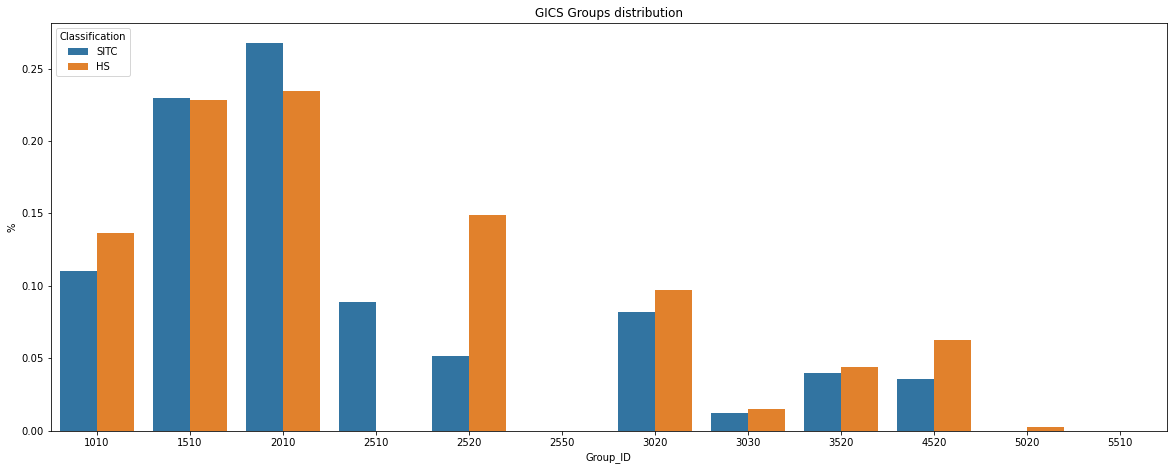

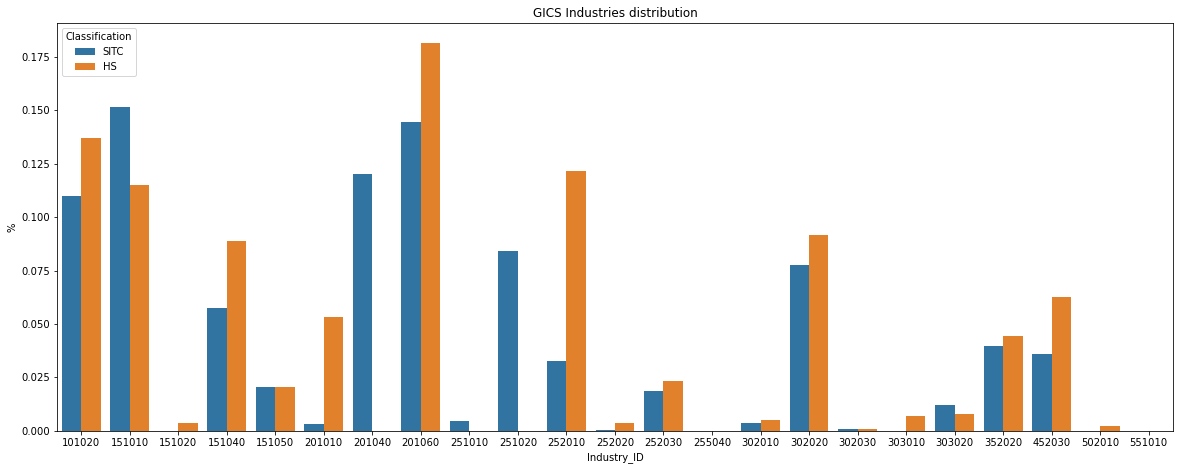

In [59]:
### TEMP

df_group_to_plot = pd.concat(dict_group_sum, axis = 1, sort = True).stack().reset_index()
df_group_to_plot.columns = ['Group_ID', 'Classification', '%']
plt.figure(figsize = (20, 7.5))
ax_groups = sns.barplot(data = df_group_to_plot, x = 'Group_ID', y = '%', hue = 'Classification')
ax_groups.set_title('GICS Groups distribution')
plt.show()
df_ind_to_plot = pd.concat(dict_industry_sum, axis = 1, sort = True).stack().reset_index()
df_ind_to_plot.columns = ['Industry_ID', 'Classification', '%']
plt.figure(figsize = (20, 7.5))
ax_industries = sns.barplot(data = df_ind_to_plot, x = 'Industry_ID', y = '%', hue = 'Classification')
ax_industries.set_title('GICS Industries distribution')
plt.show()

In [13]:
### DATA EXTRACTION FOR ACADIAN EXCHANGE MATERIALS: REGISTRIES PREPARATION

str_acadian_to_hs = 'Data_Files/Source_Files/Acadian_to_HS1992_AG4.xlsx'

df_acadian_to_hs = pd.read_excel(engine = 'openpyxl', io = str_acadian_to_hs, sheet_name = 0, 
                                 header = 0, parse_dates = False, dtype = str,
                                 na_values = list_na_excel_values, keep_default_na = False)
list_ag2_registry = sorted(df_acadian_to_hs[df_acadian_to_hs['HS Correspondent Code'] == '0000']['HS Parent Code'].unique())
list_ag4_registry = sorted(df_acadian_to_hs[df_acadian_to_hs['HS Correspondent Code'] != '0000']['HS Correspondent Code'].unique())
list_ag6_registry = sorted([iter_list[i] for iter_list in df_acadian_to_hs['AG6 Code'].dropna().str.split('\n').to_list() for i in range(len(iter_list))])

In [15]:
### DATA EXTRACTION FOR ACADIAN EXCHANGE MATERIALS: AG2 DATA COLLECTION

list_ag2_dataset = []

for df_iter_chunk in pd.read_hdf(path_or_buf = str_path_unc_raw_comm_annual, key = str_key_unc_raw, chunksize = 1000000):
    gc.collect()
    list_ag2_dataset.append(df_iter_chunk[df_iter_chunk['Commodity_ID'].isin(list_ag2_registry)])
df_ag2_data = pd.concat(list_ag2_data)
del list_ag2_dataset
gc.collect()
### Raw data saving:
df_ag2_data.to_hdf(path_or_buf = 'Data_Files/Source_Files/unc_raw_ag2_acadian.h5', key = 'acadian', mode = 'w')
del df_ag2_data
gc.collect()

57

In [ ]:
### DATA EXTRACTION FOR ACADIAN EXCHANGE MATERIALS: AG4 DATA EXTRACTION

### Concatenation aggregator initializing:
list_ag4_dataset = []
### 5-length country pairs collection:
list_empty_requests = list(itertools.product(range((len(ser_UNC_country_id.index) - 1) // int_unc_limit + 1), repeat = 2))#[ : 1]
### Looping over 5-length country pairs:
while list_empty_requests:
    iter_country_pair = list_empty_requests[0]
    iter_reporter_group = iter_country_pair[0]    
    iter_partner_group = iter_country_pair[1]
    print(iter_reporter_group * int_unc_limit, '-', (iter_reporter_group + 1) * int_unc_limit - 1, '/', 
          iter_partner_group * int_unc_limit, '-', (iter_partner_group + 1) * int_unc_limit - 1)     
    ### Country groups preparing:
    list_reporter_group = ser_UNC_country_id.iloc[iter_reporter_group * int_unc_limit : (iter_reporter_group + 1) * int_unc_limit].to_list()
    list_partner_group = ser_UNC_country_id.iloc[iter_partner_group * int_unc_limit : (iter_partner_group + 1) * int_unc_limit].to_list()    
    str_reporter_group = ','.join(ser_UNC_country_id.iloc[iter_reporter_group * int_unc_limit : (iter_reporter_group + 1) * int_unc_limit].to_list())
    str_partner_group = ','.join(ser_UNC_country_id.iloc[iter_partner_group * int_unc_limit : (iter_partner_group + 1) * int_unc_limit].to_list())    
    ### Last single country list control to avoid endless loop:
    if ((len(list_reporter_group) > 1) | (len(list_partner_group) > 1)):
        ### Request performing:
        df_iter_dataset = get_un_comtrade_data(str_reporter_group, str_partner_group, str_trade_flow = 'Both', 
                                               str_classification_code = ','.join(list_ag4_registry), str_classification_system = 'H0')
        if (len(df_iter_dataset) > 1):        
            list_ag4_dataset += [df_iter_dataset]
            print(len(df_iter_dataset), 'rows of data loaded successfully')
            list_empty_requests.remove(iter_country_pair)
        elif (df_iter_dataset.isna().sum().sum() == len(df_iter_dataset.columns)):
            print('Empty response (no data found)')
            list_empty_requests.remove(iter_country_pair)
        else:
            print('API error occured')
        gc.collect()
        time.sleep(int_seconds_to_sleep)    
    else:
        print('Two lists contains the same single country: no data')
        list_empty_requests.remove(iter_country_pair)                                
#    break

In [21]:
### DATA EXTRACTION FOR ACADIAN EXCHANGE MATERIALS: AG4 DATA SAVING

df_ag4_data = pd.concat(list_ag4_dataset)
del list_ag4_dataset
gc.collect()
### Raw data saving:
df_ag4_data.to_hdf(path_or_buf = 'Data_Files/Source_Files/unc_raw_ag4_acadian.h5', key = 'acadian', mode = 'w')
del df_ag4_data
gc.collect()

23

In [ ]:
### DATA EXTRACTION FOR ACADIAN EXCHANGE MATERIALS: AG6 DATA EXTRACTION

### Concatenation aggregator initializing:
list_ag6_dataset = []
### 5-length country pairs collection:
list_empty_requests = list(itertools.product(range((len(ser_UNC_country_id.index) - 1) // int_unc_limit + 1), repeat = 2))#[ : 1]
### Looping over 5-length country pairs:
while list_empty_requests:
    iter_country_pair = list_empty_requests[0]
    iter_reporter_group = iter_country_pair[0]    
    iter_partner_group = iter_country_pair[1]
    print(iter_reporter_group * int_unc_limit, '-', (iter_reporter_group + 1) * int_unc_limit - 1, '/', 
          iter_partner_group * int_unc_limit, '-', (iter_partner_group + 1) * int_unc_limit - 1)     
    ### Country groups preparing:
    list_reporter_group = ser_UNC_country_id.iloc[iter_reporter_group * int_unc_limit : (iter_reporter_group + 1) * int_unc_limit].to_list()
    list_partner_group = ser_UNC_country_id.iloc[iter_partner_group * int_unc_limit : (iter_partner_group + 1) * int_unc_limit].to_list()    
    str_reporter_group = ','.join(ser_UNC_country_id.iloc[iter_reporter_group * int_unc_limit : (iter_reporter_group + 1) * int_unc_limit].to_list())
    str_partner_group = ','.join(ser_UNC_country_id.iloc[iter_partner_group * int_unc_limit : (iter_partner_group + 1) * int_unc_limit].to_list())    
    ### Last single country list control to avoid endless loop:
    if ((len(list_reporter_group) > 1) | (len(list_partner_group) > 1)):
        ### Request performing:
        df_iter_dataset = get_un_comtrade_data(str_reporter_group, str_partner_group, str_trade_flow = 'Both', 
                                               str_classification_code = ','.join(list_ag6_registry), str_classification_system = 'H0')
        if (len(df_iter_dataset) > 1):        
            list_ag6_dataset += [df_iter_dataset]
            print(len(df_iter_dataset), 'rows of data loaded successfully')
            list_empty_requests.remove(iter_country_pair)
        elif (df_iter_dataset.isna().sum().sum() == len(df_iter_dataset.columns)):
            print('Empty response (no data found)')
            list_empty_requests.remove(iter_country_pair)
        else:
            print('API error occured')
        gc.collect()
        time.sleep(int_seconds_to_sleep)    
    else:
        print('Two lists contains the same single country: no data')
        list_empty_requests.remove(iter_country_pair)                                
#    break

In [16]:
### DATA EXTRACTION FOR ACADIAN EXCHANGE MATERIALS: AG6 DATA SAVING

df_ag6_data = pd.concat(list_ag6_dataset)
del list_ag6_dataset
gc.collect()
### Raw data saving:
df_ag6_data.to_hdf(path_or_buf = 'Data_Files/Source_Files/unc_raw_ag6_acadian.h5', key = 'acadian', mode = 'w')
del df_ag6_data
gc.collect()

0

In [14]:
### DATA EXTRACTION FOR ACADIAN EXCHANGE MATERIALS: PREPARING TO CONNECT

str_acadian_to_hs = 'Data_Files/Source_Files/Acadian_to_HS1992_AG4.xlsx'

df_acadian_to_hs = pd.read_excel(engine = 'openpyxl', io = str_acadian_to_hs, sheet_name = 0, 
                                 header = 0, parse_dates = False, dtype = str,
                                 na_values = list_na_excel_values, keep_default_na = False)
### AG2/AG4 connection preparing:
df_acadian_to_hs_ag4 = df_acadian_to_hs.copy()
df_acadian_to_hs_ag4.loc[df_acadian_to_hs_ag4['HS Correspondent Code'] == '0000', 'HS Correspondent Code'] = df_acadian_to_hs_ag4['HS Parent Code']
df_acadian_to_hs_ag4 = df_acadian_to_hs_ag4[['HS Correspondent Code', 'Commodity AG4']].drop_duplicates().reset_index(drop = True)
df_acadian_to_hs_ag4.columns = ['Commodity_ID', 'Commodity_Name']
df_acadian_to_hs_ag4.sort_values('Commodity_Name', inplace = True)
df_acadian_to_hs_ag4['Flag'] = 0
df_acadian_to_hs_ag4.loc[df_acadian_to_hs_ag4['Commodity_Name'].isin(df_acadian_to_hs.loc[df_acadian_to_hs['AG6 Code'].notna(), 'Commodity AG4'].values), 'Flag'] = 1
### AG6 connection preparing:
df_acadian_to_hs_ag6 = df_acadian_to_hs.copy()
df_acadian_to_hs_ag6.loc[df_acadian_to_hs_ag6['HS Correspondent Code'] == '0000', 'HS Correspondent Code'] = df_acadian_to_hs_ag6['HS Parent Code']
df_acadian_to_hs_ag6 = df_acadian_to_hs_ag6.merge(df_acadian_to_hs_ag6['AG6 Code'].str.split('\n', expand = True), left_index = True, right_index = True)
ser_acadian_to_hs_ag6 = pd.concat([df_acadian_to_hs_ag6[0], df_acadian_to_hs_ag6[1]], names = ['AG6'], keys = ['0', '1']).droplevel(0).dropna().sort_index()
ser_acadian_to_hs_ag6.name = 'Commodity_ID'
df_acadian_to_hs_ag6 = ser_acadian_to_hs_ag6.to_frame().join(df_acadian_to_hs_ag6, how = 'right')
df_acadian_to_hs_ag6.loc[df_acadian_to_hs_ag6['Commodity_ID'].isna(), 'Commodity_ID'] = \
                df_acadian_to_hs_ag6.loc[df_acadian_to_hs_ag6['Commodity_ID'].isna(), 'HS Correspondent Code']
df_acadian_to_hs_ag6 = df_acadian_to_hs_ag6[['Commodity_ID', 'Commodity AG6']].drop_duplicates().reset_index(drop = True)
df_acadian_to_hs_ag6.columns = ['Commodity_ID', 'Commodity_Name']
df_acadian_to_hs_ag6.sort_values('Commodity_Name', inplace = True)
df_acadian_to_hs_ag6 = df_acadian_to_hs_ag6[df_acadian_to_hs_ag6['Commodity_ID'].str.len() == 6]
df_acadian_to_hs_ag6['Flag'] = 2
### Aggregating connections:
df_acadian_to_hs_full = pd.concat([df_acadian_to_hs_ag4, df_acadian_to_hs_ag6]).sort_values('Commodity_ID')

In [20]:
### DATA EXTRACTION FOR ACADIAN EXCHANGE MATERIALS: CONNECTION

### Raw dara loading & concatenating:
df_ag2_acadian_raw = pd.read_hdf(path_or_buf = 'Data_Files/Source_Files/unc_raw_ag2_acadian.h5', key = 'acadian')
df_ag4_acadian_raw = pd.read_hdf(path_or_buf = 'Data_Files/Source_Files/unc_raw_ag4_acadian.h5', key = 'acadian')
df_ag6_acadian_raw = pd.read_hdf(path_or_buf = 'Data_Files/Source_Files/unc_raw_ag6_acadian.h5', key = 'acadian')
df_full_acadian_raw = pd.concat([df_ag2_acadian_raw, df_ag4_acadian_raw, df_ag6_acadian_raw], ignore_index = True)
del df_ag2_acadian_raw
del df_ag4_acadian_raw
del df_ag6_acadian_raw
gc.collect()
### Codes replacing with names:
df_full_acadian_raw['Reporter_ID'].replace(dict(zip(list(map(int, ser_UNC_country_id.values)), ser_UNC_country_id.index.to_list())), inplace = True)
df_full_acadian_raw['Partner_ID'].replace(dict(zip(list(map(int, ser_UNC_country_id.values)), ser_UNC_country_id.index.to_list())), inplace = True)
df_full_acadian_raw.loc[All, 'Partner_ID'].replace({'ZZ': 'World'}, inplace = True)
df_full_acadian_raw['Flow_ID'].replace({1: 'Import', 2: 'Export'}, inplace = True)
### Adding connections to data:
df_full_acadian_res = df_full_acadian_raw.merge(df_acadian_to_hs_full, on = 'Commodity_ID')
del df_full_acadian_raw
gc.collect()
### Data ordering:
df_full_acadian_res.columns = ['Date', 'Reporter', 'Partner', 'Flow', 'Commodity_ID', 'Value', 'Commodity_Name', 'Flag']
df_full_acadian_res.sort_values(by = ['Date', 'Reporter', 'Partner', 'Flow', 'Commodity_Name'])
df_full_acadian_res = df_full_acadian_res.astype({'Reporter': 'category', 
                                                  'Partner': 'category', 
                                                  'Flow': 'category', 
                                                  'Commodity_ID': 'category',
                                                  'Commodity_Name': 'category',
                                                  'Flag': 'category'})
### Dropping Saudi Arabia to Taiwan Export (https://unstats.un.org/wiki/display/comtrade/Taiwan%2C+Province+of+China+Trade+data) 
df_full_acadian_res.drop(df_full_acadian_res[(df_full_acadian_res['Reporter'] == 'SA') & (df_full_acadian_res['Partner'] == 'TW')].index, inplace = True)
### Data saving:
ser_full_acadian_res = df_full_acadian_res.set_index(['Date', 'Reporter', 'Partner', 'Flow', 'Commodity_ID', 'Commodity_Name', 'Flag']).squeeze()
ser_full_acadian_res.to_hdf(path_or_buf = 'Data_Files/Source_Files/unc_res_acadian.h5', key = 'acadian', mode = 'w', format = 'table', complevel = 9)